#  How Cooperation Evolves & Representation with ABM of PD 

## Barış Akovalı
## Çağan Keskin

# Prisoner's Dilemma Basics

We create a model based on agents which are playing the Prisoner's Dilemma game against eachother. 
The payoff of each game is determined as below: 


<img src="../Project/payoff.jpg" />

## Agent Definition

We define each agent with 2 parameters **probability of defection** and **memory size** (each memory slot is about one other agent)
An agent also has 3 attributes of the **score** the agent has accumulated throughout playing and the seperate slots of **memory** for cooperating and defecting agents. 
The supposed goal of the agents are to obtain the highest score so we can say an agent with a higher score is better.


In [146]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
import pandas as pd
import random
import timeit
random.seed(33)

#Memory cells for storing info about agents past games

class memory_cell():
    def __init__(self, act = 'Coop'):
        self.defect_number_ = 0.0
        self.play_number_ = 1.0
        
        if act == 'Defect' : self.defect_number_ += 1.0
    
    def update(self, act):
        if act == 'Defect' : self.defect_number_ += 1.0
        self.play_number_ += 1.0
    
    def impression(self):
        #The evaluation of the defect/play ratio of the agent in memory
        return self.defect_number_/max(1.0, self.play_number_)

# Agent class that plays the game
    
class agent():
 
    def __init__(self, ID, pD = 1, M = 1):
        self.ID = ID
        self.pD = pD
        self.capacity = M
        self.score_ = 0
        
        self.memory_for_defectors_ = dict()
        self.memory_for_cooperators_ = dict()
        
    def act(self):
        # Return defection or cooperation based on the agents probability of defection attribute
        if np.random.rand() < self.pD:
            return 'Defect'
        return 'Coop'
    
    def know(self, other):
        #Checks if the current agent has the other agent in memory
        return (other in self.memory_for_defectors_) or (other in self.memory_for_cooperators_)
    
    def is_memory_full(self):
        #Checks if memory is full
        c,d = len(self.memory_for_cooperators_), len(self.memory_for_defectors_)
        return  c + d >= self.capacity
    
    def perceive_as_defector(self, other):
        #Checks if another agent is a defector
        return other in self.memory_for_defectors_
    
    def perceive_as_cooperator(self, other):
        #Checks if another agent is a cooperator
        return other in self.memory_for_cooperators_
    
    def add_payoff(self, payoff):
        #Add a payoff to agents score value
        self.score_ += payoff
    
    def learn(self, other, act):
        #The function for playing against another agent and adding them to memory
        if other in self.memory_for_defectors_:
            print("defector- don't play")
        elif other in self.memory_for_cooperators_:
            self.memory_for_cooperators_[other].update(act)
            
            # Checks the evaluation of cooperator and if ratio is bigger than 1/2 for defection transfers it to defector memory
            if self.memory_for_cooperators_[other].impression() > 0.5:
                self.memory_for_defectors_[other] = self.memory_for_cooperators_[other]
                del self.memory_for_cooperators_[other]
        else: 
            # Plays with an unknown agent
            if self.is_memory_full(): 
                self.forget()
            if act == 'Coop':
                self.memory_for_cooperators_[other] = memory_cell(act)
            else:
                self.memory_for_defectors_[other] = memory_cell(act)
        
    def forget(self):  
        #Deleting an agent from memory randomly
        if len(self.memory_for_cooperators_) > 0:
            f = random.choice(list(self.memory_for_cooperators_.keys()))
            del self.memory_for_cooperators_[f]
        else:
            f = random.choice(list(self.memory_for_defectors_.keys()))
            del self.memory_for_defectors_[f]

    def display(self):
        #For showing as table
        return [(k.ID, v.impression()) for (k,v) in self.memory_for_cooperators_.items()] + [(k.ID, v.impression()) for (k,v) in self.memory_for_defectors_.items()]

## The Model

Now we have the agents to play the game but we are required to create the model that the agents will interact with eachother. The parameters for the model are as follows: **number of agents** in the model, **memory size** for all agents in the model, the **population** that contains the features of each agent, the **time** variable to determine the amount of games played in the model and finally the **payoff matrix** of the game to be used(this is shown in the image above).

In [147]:
class model():
    def __init__(self, N = 10, M = 9, tau = 30, payoff = {'CC':3,'CD':0,'DC':5,'DD':1}):
        self.N = N
        self.time = self.N * self.N * tau
        self.population = [agent(i, pD = np.random.rand(), M = M) for i in range(self.N)]
        self.payoff = payoff
        
    def world(self):
        for i in range(self.time):
            iA, iB = np.random.choice(range(self.N), 2, replace=False)
            A, B = self.population[iA], self.population[iB]
            
            # Decision to interact
            if B.perceive_as_defector(A): continue
            if A.perceive_as_defector(B): continue
            
            A_action, B_action = A.act(), B.act()
            A.learn(B, B_action)
            B.learn(A, A_action)

            A.add_payoff(self.payoff[A_action[:1]+B_action[:1]])
            B.add_payoff(self.payoff[B_action[:1]+A_action[:1]])
            
    def display(self):
        df = pd.DataFrame(columns=['ID','ProbDef', 'Score', 'Init Mem', 'Mem Len', 'Memory'])
        for A in self.population:
            df.loc[A.ID] = pd.Series({'ID':A.ID, 'ProbDef':A.pD, 'Score':A.score_, 'Init Mem': A.capacity, 
                                      'Mem Len': len(A.memory_for_cooperators_) + len(A.memory_for_defectors_), 
                                      'Memory':A.display()})
        return df

### Analyzing the model 
Now we have a fully functional model with agents in it able to play the PD game. So we can observe the behaviour and the strategies that have a better score and such. The critical features to observe change are the memory size and payoff matrix. 
We can see how an increase/decrease in overall memory of agents effect strategies employed and the score. By changing the payoff matrix we can simulate more forgiving/dangerous environments.

### Base Graph of our Model

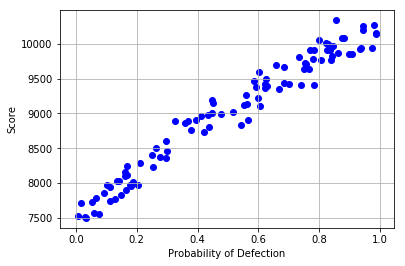

In [148]:
# Lets generate 100 agents with memory size 20 for each
sim = model(100, 20)
#Play for (N * time) times (time default is 30)
sim.world()
result = sim.display()

plt.scatter(result.ProbDef, result.Score, color = 'blue')
plt.xlabel('Probability of Defection');plt.ylabel('Score');
plt.grid()

#### We can observe that with a memory size of 20 the Defectors have better results

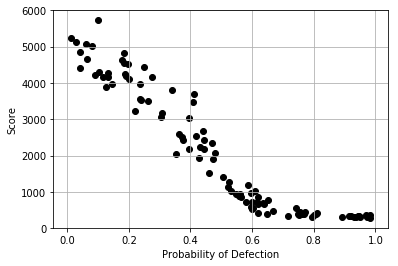

In [149]:
# Lets generate 100 agents with memory size 100 for each
sim = model(100, 100)
#Play for (N * time) times (time default is 30)
sim.world()
result = sim.display()

plt.scatter(result.ProbDef, result.Score, color = 'black')
plt.xlabel('Probability of Defection');plt.ylabel('Score');
plt.grid()

#### With the increase in the memory to population size we can see that Defectors barely have any points and Cooperators are in a huge advantage. However it should be noted that the max score for an agent has also decreased.

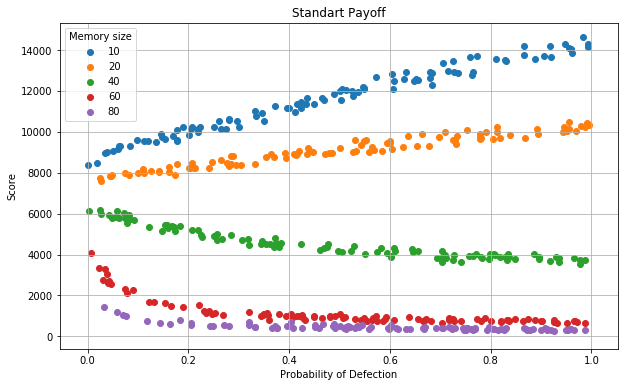

In [150]:
plt.figure(figsize = (10,6))
for m in [10,20,40,60, 80]:
    sim = model(N = 100, M= m)
    sim.world()
    result = sim.display()
    plt.scatter(result.ProbDef, result.Score, label = str(m))
    plt.xlabel('Probability of Defection');plt.ylabel('Score');
    plt.legend(title="Memory size")
    plt.title("Standart Payoff")
    plt.grid()

#### From this graph we can observe the change in strategy from defection to cooperation between the memory size 20 and 40 and notice the overall score gain decreases as memory increases.

### Observing Change relative to Environment
Up until this point we manipulated the memory of agents to observe change now we will consider the idea of changing the payoff matrix so we can set up "dangerous or forgiving" envinronments for our agents.

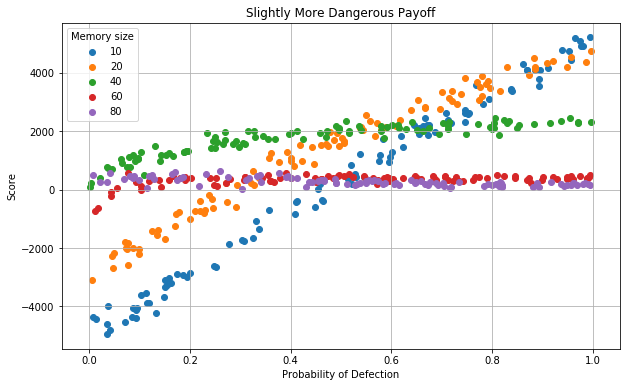

In [151]:
#Payoff matrix for simulating a more dangerous environment
payoff_matrix = {'CC':3,'CD':-5,'DC':5,'DD':-3}
plt.figure(figsize = (10,6))
for m in [10,20,40,60, 80]:
    sim = model(N = 100, M= m, payoff = payoff_matrix)
    sim.world()
    result = sim.display()
    plt.scatter(result.ProbDef, result.Score, label = str(m))
    plt.xlabel('Probability of Defection');plt.ylabel('Score');
    plt.legend(title="Memory size")
    plt.title("Slightly More Dangerous Payoff")
    plt.grid()

#### We can see that in a slightly more dangerous environment defectors still have an advantage in low memory capacity agents, however the scores reach an equilibrium at higher memory capacity. 

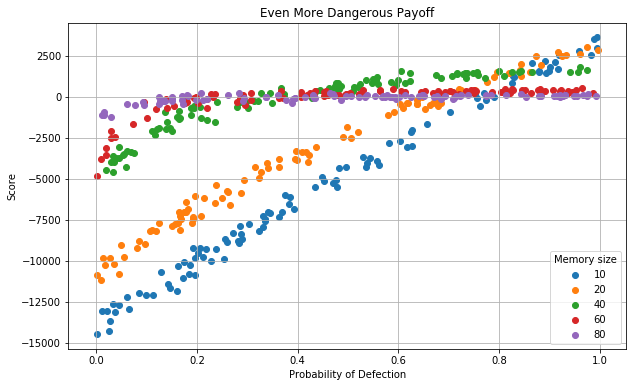

In [152]:
#Payoff matrix for simulating a more dangerous environment
payoff_matrix = {'CC':3,'CD':-10,'DC':5,'DD':-5}
plt.figure(figsize = (10,6))
for m in [10,20,40,60,80]:
    sim = model(N = 100, M= m, payoff = payoff_matrix)
    sim.world()
    result = sim.display()
    plt.scatter(result.ProbDef, result.Score, label = str(m))
    plt.xlabel('Probability of Defection');plt.ylabel('Score');
    plt.legend(title="Memory size")
    plt.title("Even More Dangerous Payoff")
    plt.grid()

#### To conclude we can see that the most dangerous environment is only suitable for defectors the only way for cooperators to compete is an increase in memory capacity.

## Conclusion to Memory and Environment
So considering these results we can say in higher danger environments biased against cooperators memory is the way to combat it. However it should be noted that an increase in memory shows a decrease in the avg score of the population if the environment is forgiving. So now our goal should be to design agents able to evolve based on the requirements of the environment and create a model accordingly.
#### ------------------------------------------------------------------------------------------------------------------------------------------------------

## Evolutionary Agents and Evolution
The idea of evolution is to modify agents throughout the game's lifetime so that they converge towards a strategy that gains them the most amount of points. We can achieve this model by adding few features to our agent and model.
### The EAgent
We can accomplish the function of evolution in our agent by adding a **genome** feature that determines the **probability of defection** and **memory size** so it can be modified by other functions. We will also add a function to set this genome and reset the agent.


In [153]:
class EAgent(agent):
    def __init__(self, ID, pD = 1.0, MRatio = 1.0 , N =100):
        #Genome determines pD and memory
        self.N = N
        self.genome = np.array([pD, MRatio])
        super().__init__(ID, pD = self.genome[0], M = N * self.genome[1])
        
    def set_gene(self, new_gene):
        #Sets a new genome
        self.genome = new_gene
        self.reset()
        
    def reset(self):
        #Resets attributes of agent
        self.pD = self.genome[0]
        self.capacity = self.N * self.genome[1]
        self.score_ = 0
        
        self.memory_for_defectors_.clear()
        self.memory_for_cooperators_.clear()
        
    def fitness(self):
        return self.score_

### The EModel
The Evolutionary model is mostly the same as the model from before with the added function for creating a new population

In [154]:
class EModel():
    def __init__(self, N = 50, tau = 20, payoff = {'CC':3,'CD':0,'DC':5,'DD':1}):
        self.N = N
        self.time = self.N * self.N * tau
        self.population = [EAgent(i, pD = np.random.rand(), MRatio = np.random.rand(), N = self.N) for i in range(self.N)]
        self.payoff = payoff
        
    def renaissance(self, new_population):
        self.population = new_population
        for player in self.population:
            player.reset()
        
    def world(self):
        for i in range(self.time):
            iA, iB = np.random.choice(range(self.N), 2, replace=False)
            A, B = self.population[iA], self.population[iB]
            
            # Decision to interact
            if B.perceive_as_defector(A): continue
            if A.perceive_as_defector(B): continue
            
            A_action, B_action = A.act(), B.act()
            A.learn(B, B_action)
            B.learn(A, A_action)

            A.add_payoff(self.payoff[A_action[:1]+B_action[:1]])
            B.add_payoff(self.payoff[B_action[:1]+A_action[:1]])
       
    def display(self):
        self.df = pd.DataFrame(columns=['ID','pD', 'mRatio', 'Score'])
        for A in self.population:
            self.df.loc[A.ID] = pd.Series({'ID':A.ID, 'pD':A.genome[0], 'mRatio':A.genome[1], 'Score':A.score_})
        return self.df

## The Evolution
The evolution class inherits the EModel and few extra functions. This class handles the **evolution** of the agents and functions like reproduction, mutation and creating a new population. 
#### The explanation for the functions are given in-line

In [155]:
class evolution():
    def __init__(self, N = 50, tau = 30, payoff = {'CC':3,'CD':0,'DC':5,'DD':1}): 
        self.sim = EModel(N = N, tau = tau, payoff = payoff)
        self.sim.world()
        
        self.N = N
        self.population = self.sim.population
        self.update_probabilities()
        self.df_evolution = [self.sim.display()]

    def update_probabilities(self):
        #Determine the probability assigned to each agent to be used for reproduction
        self.success = {i: self.population[i].fitness() for i in range(self.N)} 
        #Convert negative payoffs into probabilities, we substract min
        min_success = min(self.success.values()) 
        for i in range(self.N):
            self.success[i] = self.success[i] - min_success
        
        total_success = sum(self.success.values())
        self.reproduction_probability = {i: self.success[i]/total_success for i in range(self.N)}

    def selection(self):
        #Makes the selection of agents based on the reproduction probability 
        pr = [self.reproduction_probability[i] for i in range(self.N)] #Span probabilities of reproduction across the agents
        select = np.random.choice(self.N, 2, replace= False, p=pr)
        return select
    
    def crossover(self, selectedParents):
        #This method allows variance by mixing genomes from two diff agents
        parent0 = self.population[selectedParents[0]].genome
        parent1 = self.population[selectedParents[1]].genome

        cut = np.random.randint(len(parent0)-1) + 1 # to avoid cut = 0 (exact copy of parent1)
        child_gene = np.hstack((parent0[:cut],parent1[cut:]))
        return child_gene
    
    def mutation(self, child_gene, p = 1):
        #The random mutation factor which adds a small unpredictability to the reproduction step
        mutation_point = np.random.randint(len(child_gene))
        if np.random.rand() < p:
            child_gene[mutation_point] = np.random.rand()
        return child_gene
    
    def create_offspring(self):
        #Create the new gene to be inserted into an agent
        parents = self.selection()
        child_gene = self.crossover(parents)
        
        child_gene = self.mutation(child_gene)
        return child_gene
    
    def create_new_population(self):
        #Creating new population using created genes take from most succesful agents in the existing model
        sorted_by_success = sorted(self.success.items(), key=lambda kv: kv[1])
        self.best_agent = self.population[sorted_by_success[-1][0]]
        
        for i in range(self.N//2):
            child_gene = self.create_offspring()
            agent_id = sorted_by_success[i][0]
            self.population[agent_id].set_gene(child_gene)
        
        self.sim.renaissance(self.population)
        self.sim.world()
        self.df_evolution.append(self.sim.display())
        
        self.update_probabilities()
    
    def evolve(self, G ):
        #Number of times to evolve aka repeat the procces of reproduction and creating new population
        for i in range(G):
            if i % (G//5) == 0: print(i, len(self.df_evolution))
            self.create_new_population()
        return self.best_agent

## Analysis of Evolution Model
With the evolution model we can now observe how the population reacts to changes in environment and what strategies they employ when in high-danger or forgiving environments. We will changing the initial payoff matrix to observe the changes in the **probability of defection** and the **Memory ratio** of the agents

0 1
10 11
20 21
30 31
40 41


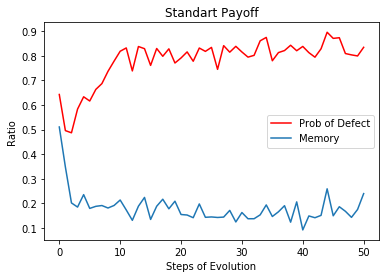

In [156]:
#Analysis of the default payoff with 50 steps
world = evolution()
world.evolve(G = 50)

pD = [world.df_evolution[i].pD.mean() for i in range(len(world.df_evolution))]
m = [world.df_evolution[i].mRatio.mean() for i in range(len(world.df_evolution))]

plt.plot(pD, label = "Prob of Defect", color = 'r')
plt.plot(m, label = "Memory")
plt.xlabel('Steps of Evolution');plt.ylabel('Ratio');
plt.title("Standart Payoff")
plt.legend()

### The Standart Payoff
We can observe that the agents converge on a lower memory capacity and higher defection rate than the beginning this behavior is logical in terms of the games rules and the **Nash Equilibrium** and keeps the status quo of agents defecting in majority.

0 1
10 11
20 21
30 31
40 41


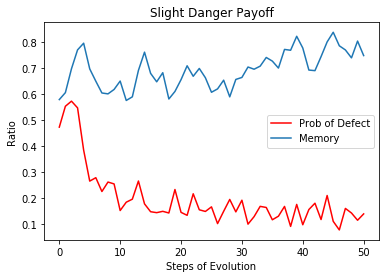

In [157]:
#Analysis of the slight danger payoff with 50 steps
world = evolution(payoff = {'CC':3,'CD':-5,'DC':5,'DD':-3})
world.evolve(G = 50)

pD= [world.df_evolution[i].pD.mean() for i in range(len(world.df_evolution))]
m = [world.df_evolution[i].mRatio.mean() for i in range(len(world.df_evolution))]

plt.plot(pD,label = "Prob of Defect", color = 'r')
plt.plot(m, label = "Memory")
plt.xlabel('Steps of Evolution');plt.ylabel('Ratio');
plt.title("Slight Danger Payoff")
plt.legend()

### The Slight Danger Payoff
This example shows the opposite of the standart payoff and we can observe the agents employing an increase in memory at the start against a high defection rate. Due to this the defectors starve out and the prob defection converges near the low end as the memory converges near the high end.

0 1
40 41
80 81
120 121
160 161


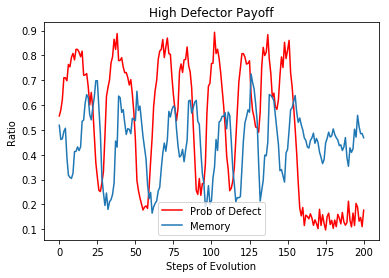

In [158]:
#High payoff for defector if it wins
world = evolution(payoff = {'CC':3,'CD':-2,'DC':6,'DD':-1})
world.evolve(G = 200)

pD = [world.df_evolution[i].pD.mean() for i in range(len(world.df_evolution))]
m = [world.df_evolution[i].mRatio.mean() for i in range(len(world.df_evolution))]

plt.plot(pD, label = "Prob of Defect", color = 'r')
plt.plot(m, label = "Memory")
plt.xlabel('Steps of Evolution');plt.ylabel('Ratio');
plt.title("High Defector Payoff")
plt.legend()

### The High Defector Payoff
From this graph we can clearly see that in response to high amounts of defectors the agents respond with an increase in memory and unlike the slight danger payoff this behaviour is consistent and there is a back and forth between cooperators and defectors.

0 1
40 41
80 81
120 121
160 161


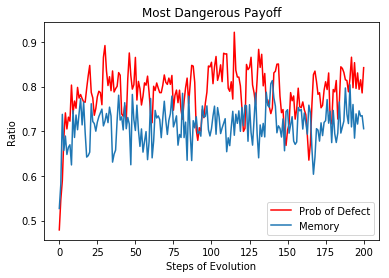

In [159]:
#Analysis of the most dangerous payoff with 200 steps
world = evolution(payoff = {'CC':3,'CD':-10,'DC':5,'DD':-5})
world.evolve(G = 200)

pD = [world.df_evolution[i].pD.mean() for i in range(len(world.df_evolution))]
m = [world.df_evolution[i].mRatio.mean() for i in range(len(world.df_evolution))]

plt.plot(pD, label = "Prob of Defect", color = 'r')
plt.plot(m, label = "Memory")
plt.xlabel('Steps of Evolution');plt.ylabel('Ratio');
plt.title("Most Dangerous Payoff")
plt.legend()


## The Conclusion
To sumarise the results obtained we can say the following: 

#### Memory is used to combat against a defector heavy environment
#### High Memory Capacity is unnecessary in environments with no threat
#### Low Memory Capacity agents are vulnerable to High Defector Strategies

## Further Improvements 
The results obtained share some insight on how cooperation can be a valid strategy in a game where defector strategy is logically superior. However this representation could be improved several ways we make many assumptions while computing the interactions (for example having a "don't play" condition for defectors) and these rules are an extra to the base Prisoner's Dilemma game. To be more truthful to the game and real life scenarios we could add another model which is made by using the memory data to influence the probability of playing other agents and adding extra features for more detailed analysis. 
### Community Interactions
This model ignores the overall score generated by the model itself and considers the score generated by agents seperately. If we would like to make comparisons and competitions between communities playing the PD game we would have to again modify the model.